# Spleen 3D segmentation with MONAI

This tutorial shows how to integrate MONAI into an existing PyTorch medical DL program.

And easily use below features:
1. Transforms for dictionary format data.
1. Load Nifti image with metadata.
1. Add channel dim to the data if no channel dimension.
1. Scale medical image intensity with expected range.
1. Crop out a batch of balanced images based on positive / negative label ratio.
1. Cache IO and transforms to accelerate training and validation.
1. 3D UNet model, Dice loss function, Mean Dice metric for 3D segmentation task.
1. Sliding window inference method.
1. Deterministic training for reproducibility.

The Spleen dataset can be downloaded from http://medicaldecathlon.com/.

![spleen](figures/spleen0.png)

Target: Spleen  
Modality: CT  
Size: 61 3D volumes (41 Training + 20 Testing)  
Source: Memorial Sloan Kettering Cancer Center  
Challenge: Large ranging foreground size

## Setup environment

In [1]:
import os

# Set the environment variable to allow duplicate OpenMP libraries
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [2]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

C:\Users\qmeda\AppData\Roaming\Python\Python312\site-packages\ignite\handlers\checkpoint.py:17: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


## Setup imports

In [3]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
from torch.utils.tensorboard import SummaryWriter
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

print_config()

C:\Users\qmeda\AppData\Roaming\Python\Python312\site-packages\ignite\handlers\checkpoint.py:17: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


MONAI version: 1.6.dev2537
Numpy version: 1.26.4
Pytorch version: 2.4.1+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: ca9fa44c33f3b7c073263938e7a70b2fa6123044
MONAI __file__: C:\Users\<username>\AppData\Roaming\Python\Python312\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.23.2
scipy version: 1.13.1
Pillow version: 10.3.0
Tensorboard version: 2.20.0
gdown version: 5.2.0
TorchVision version: 0.19.1+cpu
tqdm version: 4.66.4
lmdb version: 1.4.1
psutil version: 5.9.0
pandas version: 2.2.2
einops version: 0.8.0
transformers version: 4.44.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#

## Download Dataset from GDrive

In [4]:
import os
import gdown
import zipfile

# Google Drive file ID
file_id = '1UJCFGUexYGPZ__w02Vd2QIucACjT-kyM'

root_dir = os.getcwd()
print(f"Using current directory as root: {root_dir}")

compressed_file = os.path.join(root_dir, "Spleen.zip")
data_root_dir = os.path.join(root_dir, "Task09_Spleen")
final_data_dir = os.path.join(data_root_dir, "Task09_Spleen")
print(f"Using current dataset directory: {final_data_dir}")

# Check if the final data directory already exists
if not os.path.exists(final_data_dir):
    print("Downloading...")
    gdown.download(f'https://drive.google.com/uc?id={file_id}', compressed_file, quiet=False)
    print("Download complete.")

    print("Unzipping...")
    try:
        # Extract the contents to the 'Task09_Spleen' folder, not the nested one
        with zipfile.ZipFile(compressed_file, 'r') as zip_ref:
            zip_ref.extractall(data_root_dir)
        print("Unzipping complete.")
    except zipfile.BadZipFile:
        print("Error: The downloaded file is corrupted or not a valid zip file.")
        if os.path.exists(compressed_file):
            os.remove(compressed_file)
else:
    print("Data directory already exists. Skipping download and extraction.")

Using current directory as root: d:\NVIDIA MONAI WORKSHOP\Notebook
Using current dataset directory: d:\NVIDIA MONAI WORKSHOP\Notebook\Task09_Spleen\Task09_Spleen
Data directory already exists. Skipping download and extraction.


## Set MSD Spleen dataset path

In [5]:
train_images = sorted(glob.glob(os.path.join(final_data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(final_data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

print(f"Number of training files: {len(train_files)}")
print(f"Number of validation files: {len(val_files)}")

Number of training files: 32
Number of validation files: 9


## Set deterministic training for reproducibility

In [6]:
set_determinism(seed=0)

## Setup transforms for training and validation

Here we use several transforms to augment the dataset:
1. `LoadImaged` loads the spleen CT images and labels from NIfTI format files.
1. `EnsureChannelFirstd` ensures the original data to construct "channel first" shape.
1. `Orientationd` unifies the data orientation based on the affine matrix.
1. `Spacingd` adjusts the spacing by `pixdim=(1.5, 1.5, 2.)` based on the affine matrix.
1. `ScaleIntensityRanged` extracts intensity range [-57, 164] and scales to [0, 1].
1. `CropForegroundd` removes all zero borders to focus on the valid body area of the images and labels.
1. `RandCropByPosNegLabeld` randomly crop patch samples from big image based on pos / neg ratio.  
The image centers of negative samples must be in valid body area.
1. `RandAffined` efficiently performs `rotate`, `scale`, `shear`, `translate`, etc. together based on PyTorch affine transform.

In [7]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image", allow_smaller=True),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image", allow_smaller=True),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)

C:\Users\qmeda\AppData\Roaming\Python\Python312\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.
  warn_deprecated(argname, msg, warning_category)


## Check transforms in DataLoader

image shape: torch.Size([228, 158, 113]), label shape: torch.Size([228, 158, 113])


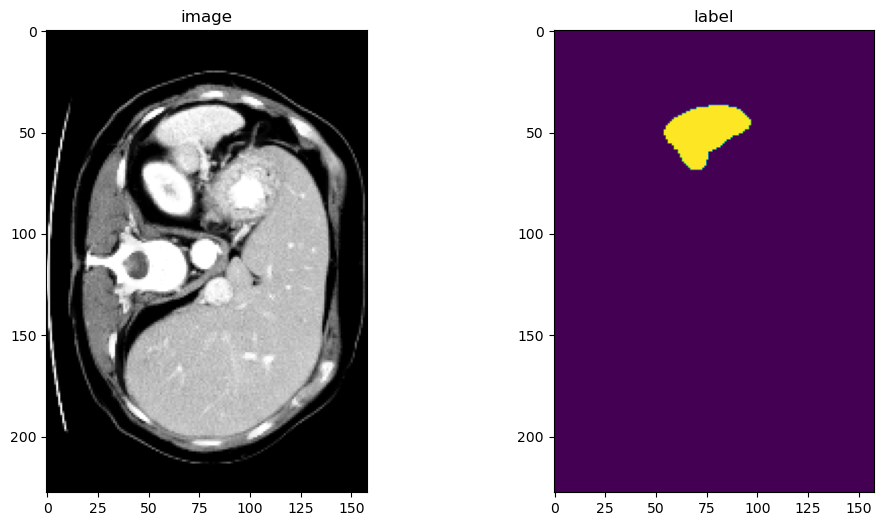

In [8]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 80])
plt.show()

## Define CacheDataset and DataLoader for training and validation

Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.  
To achieve best performance, set `cache_rate=1.0` to cache all the data, if memory is not enough, set lower value.  
Users can also set `cache_num` instead of `cache_rate`, will use the minimum value of the 2 settings.  
And set `num_workers` to enable multi-threads during caching.  
If want to to try the regular Dataset, just change to use the commented code below.

In [9]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=0)
# train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=0)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=0)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=0)

Loading dataset: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


## Check VRAM Usage

In [10]:
# Check initial VRAM usage
initial_vram = torch.cuda.memory_allocated()
print(f"Initial VRAM usage: {initial_vram / 1024**2:.2f} MB")

!nvidia-smi

Initial VRAM usage: 0.00 MB
Thu Sep 18 11:17:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.97                 Driver Version: 576.97         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 Ti   WDDM  |   00000000:01:00.0  On |                  N/A |
| 30%   31C    P8              7W /  160W |     472MiB /   8188MiB |     30%      Default |
|                                         |                        |                  N/A |
+-------------------

## Create Model, Loss, Optimizer

In [11]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

# Create a SummaryWriter instance
writer = SummaryWriter()

model_vram = torch.cuda.memory_allocated()
print(f"VRAM after model creation: {model_vram / 1024**2:.2f} MB")

# Reset max memory tracking
torch.cuda.reset_peak_memory_stats()

VRAM after model creation: 18.40 MB


## Execute a typical PyTorch training process

In [12]:
max_epochs = 10  # Increase for better results
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    # Log the average epoch loss to TensorBoard
    writer.add_scalar("Training/Loss", epoch_loss, epoch + 1)

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

            # Log the mean Dice metric to TensorBoard
            writer.add_scalar("Validation/Dice", metric, epoch + 1)

----------
epoch 1/10
1/16, train_loss: 0.6777
2/16, train_loss: 0.6788
3/16, train_loss: 0.6720
4/16, train_loss: 0.6809
5/16, train_loss: 0.6878
6/16, train_loss: 0.6947
7/16, train_loss: 0.6638
8/16, train_loss: 0.6831
9/16, train_loss: 0.6674
10/16, train_loss: 0.6433
11/16, train_loss: 0.6674
12/16, train_loss: 0.6797
13/16, train_loss: 0.6302
14/16, train_loss: 0.6513
15/16, train_loss: 0.6513
16/16, train_loss: 0.6450
epoch 1 average loss: 0.6671
----------
epoch 2/10
1/16, train_loss: 0.6700
2/16, train_loss: 0.6555
3/16, train_loss: 0.6283
4/16, train_loss: 0.6494
5/16, train_loss: 0.6607
6/16, train_loss: 0.6234
7/16, train_loss: 0.6344
8/16, train_loss: 0.6366
9/16, train_loss: 0.6304
10/16, train_loss: 0.6630
11/16, train_loss: 0.6135
12/16, train_loss: 0.5966
13/16, train_loss: 0.6232
14/16, train_loss: 0.6525
15/16, train_loss: 0.6423
16/16, train_loss: 0.6554
epoch 2 average loss: 0.6397
saved new best metric model
current epoch: 2 current mean dice: 0.0314
best mean dic

## Tensorboard to show the training loss and validation loss

- Go to terminal window (cmd) to run `tensorboard --logdir=runs`.
- Vist `http://localhost:6006/` in the browser for the visualization of the tensorboard.


In [ ]:
%load_ext tensorboard
%tensorboard --logdir=runs

In [14]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}"
)

# Close the SummaryWriter
writer.close()

train completed, best_metric: 0.0648 at epoch: 10


## Check Final VRAM Usage

In [15]:
final_vram = torch.cuda.max_memory_allocated()
print(f"Final Peak VRAM during training: {final_vram / 1024**2:.2f} MB")

print(f"Current VRAM: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")

!nvidia-smi

Final Peak VRAM during training: 1684.37 MB
Current VRAM: 276.81 MB
Thu Sep 18 11:18:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.97                 Driver Version: 576.97         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 Ti   WDDM  |   00000000:01:00.0  On |                  N/A |
| 30%   58C    P2            114W /  160W |    3532MiB /   8188MiB |     96%      Default |
|                                         |                        |    

## Plot the loss and metric

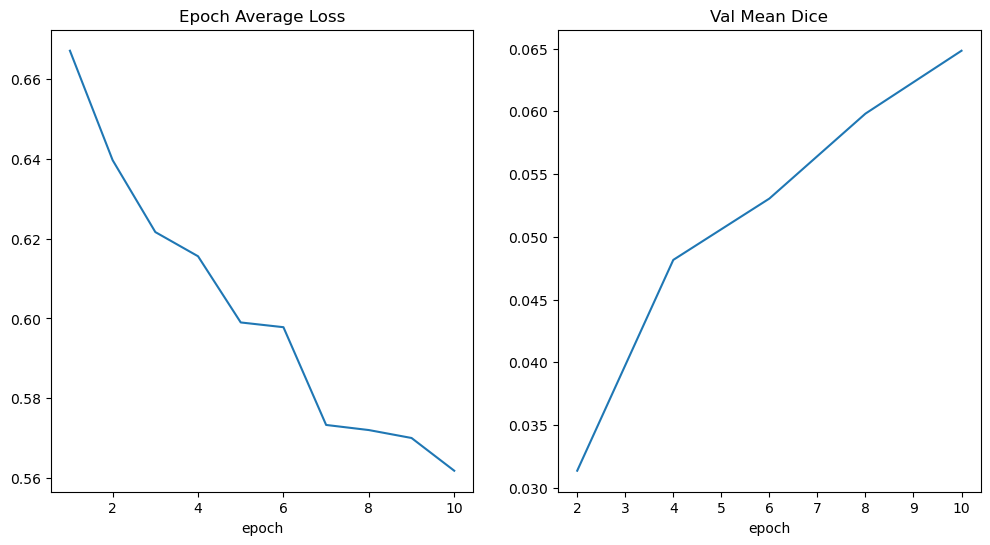

In [16]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Check best model output with the input image and label

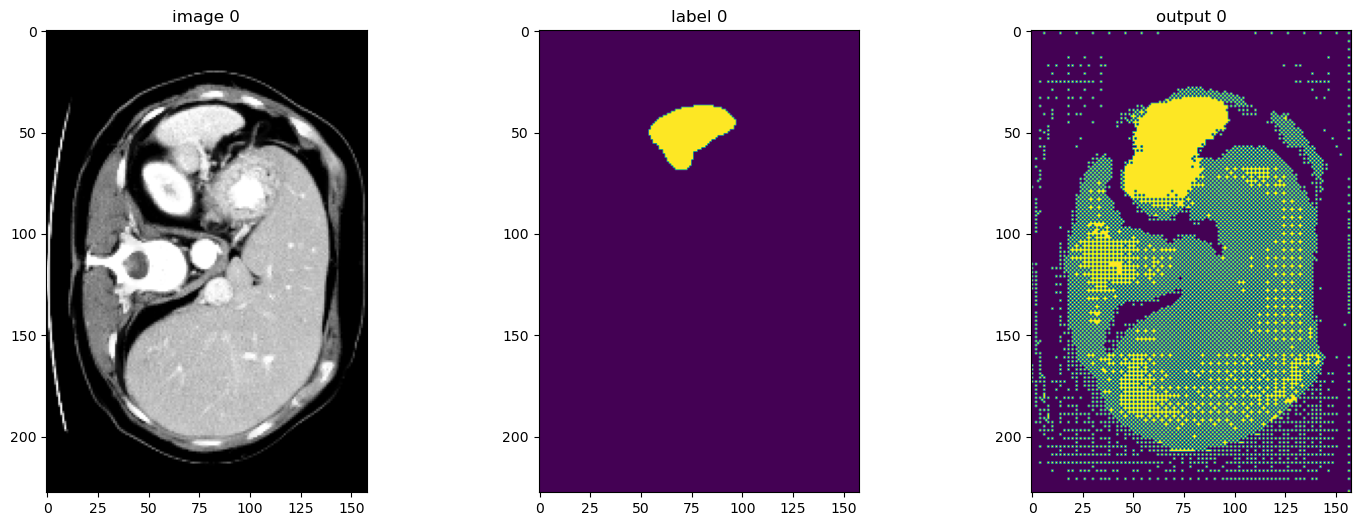

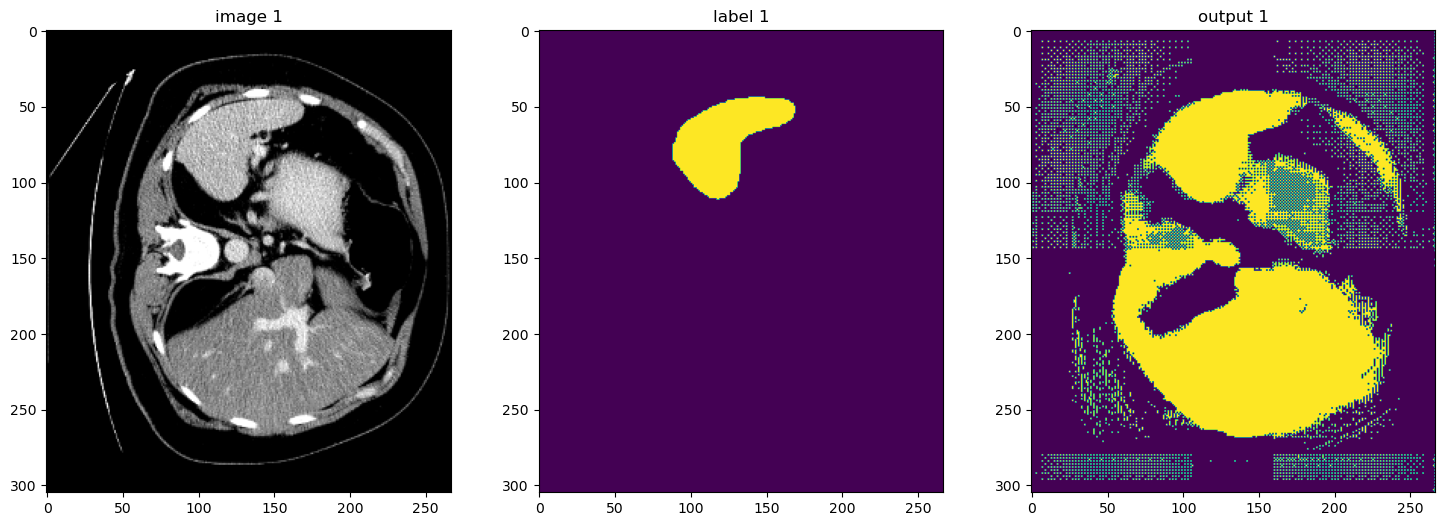

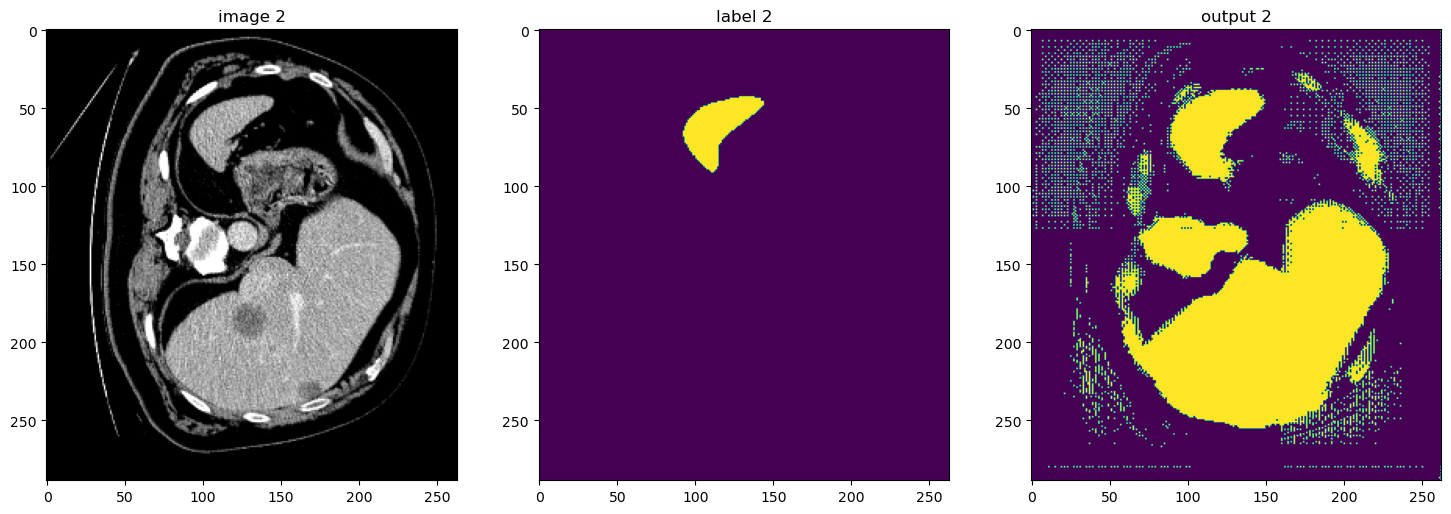

In [17]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth"), weights_only=True))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()
        if i == 2:
            break

## Evaluation on original image spacings

In [18]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.5, 1.5, 2.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image", allow_smaller=True),
    ]
)

val_org_ds = Dataset(data=val_files, transform=val_org_transforms)
val_org_loader = DataLoader(val_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=val_org_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
            device="cpu",
        ),
        AsDiscreted(keys="pred", argmax=True, to_onehot=2),
        AsDiscreted(keys="label", to_onehot=2),
    ]
)

In [19]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth"), weights_only=True))
model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_data["pred"] = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        # compute metric for current iteration
        dice_metric(y_pred=val_outputs, y=val_labels)

    # aggregate the final mean dice result
    metric_org = dice_metric.aggregate().item()
    # reset the status for next validation round
    dice_metric.reset()

print("Metric on original image spacing: ", metric_org)

Metric on original image spacing:  0.06785472482442856


## Inference on Test Set

In [20]:
test_images = sorted(glob.glob(os.path.join(final_data_dir, "imagesTs", "*.nii.gz")))

test_data = [{"image": image} for image in test_images]


test_org_transforms = Compose(
    [
        LoadImaged(keys="image"),
        EnsureChannelFirstd(keys="image"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.5, 1.5, 2.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image", allow_smaller=True),
    ]
)

test_org_ds = Dataset(data=test_data, transform=test_org_transforms)

test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=test_org_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
        ),
        AsDiscreted(keys="pred", argmax=True, to_onehot=2),
        SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./out", output_postfix="seg", resample=False),
    ]
)

In [21]:
# # uncomment the following lines to visualize the predicted results
from monai.transforms import LoadImage
loader = LoadImage()

2025-09-18 11:19:22,961 INFO image_writer.py:197 - writing: out\spleen_1\spleen_1_seg.nii.gz


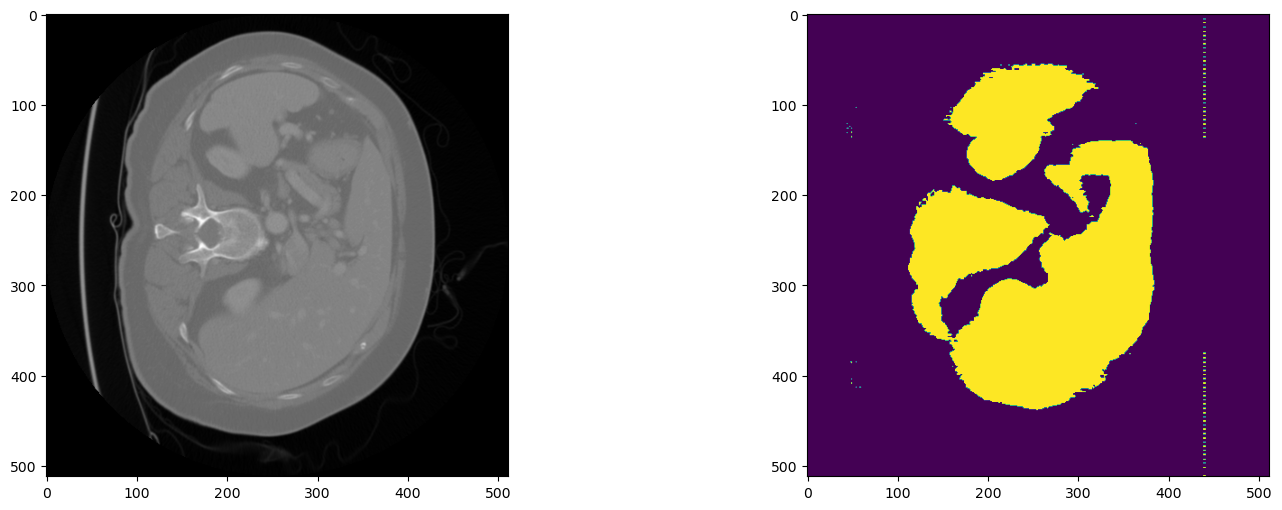

2025-09-18 11:19:25,174 INFO image_writer.py:197 - writing: out\spleen_11\spleen_11_seg.nii.gz


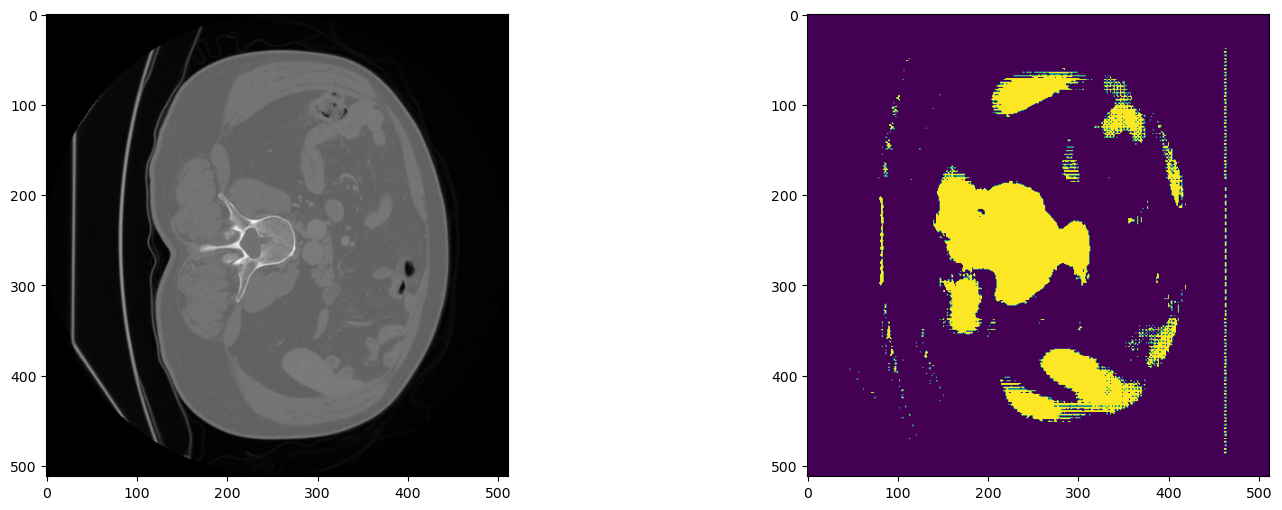

2025-09-18 11:19:29,308 INFO image_writer.py:197 - writing: out\spleen_15\spleen_15_seg.nii.gz


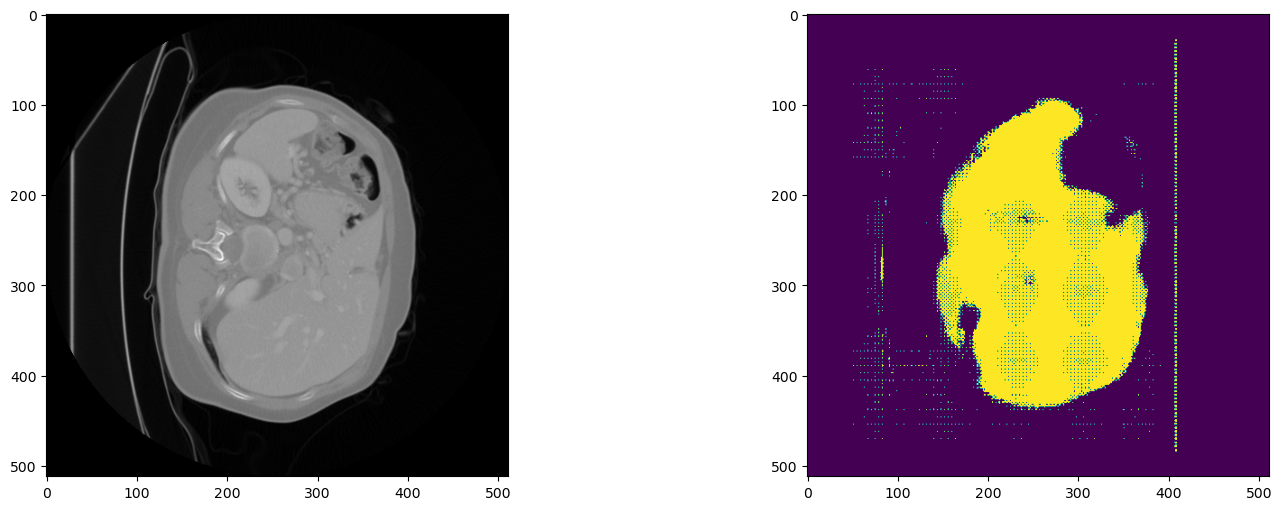

2025-09-18 11:19:30,474 INFO image_writer.py:197 - writing: out\spleen_23\spleen_23_seg.nii.gz


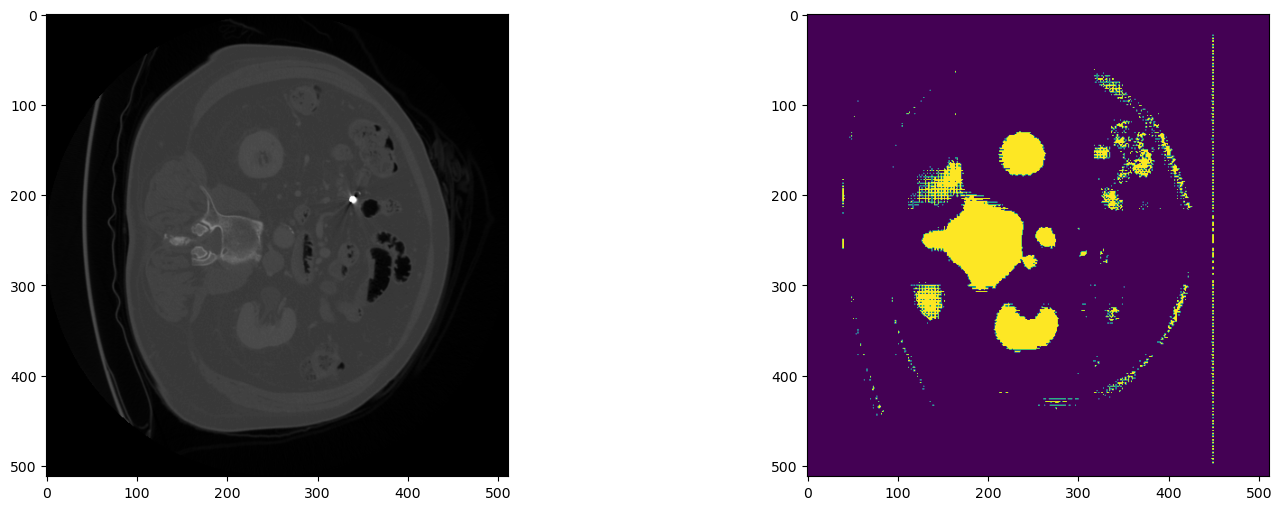

2025-09-18 11:19:32,945 INFO image_writer.py:197 - writing: out\spleen_30\spleen_30_seg.nii.gz


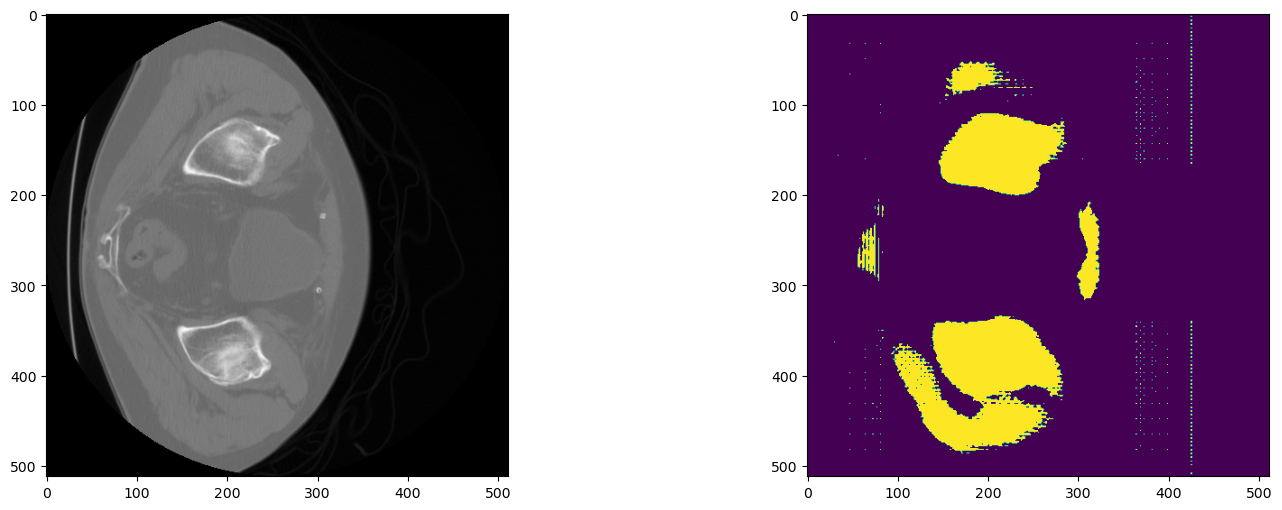

2025-09-18 11:19:35,239 INFO image_writer.py:197 - writing: out\spleen_34\spleen_34_seg.nii.gz


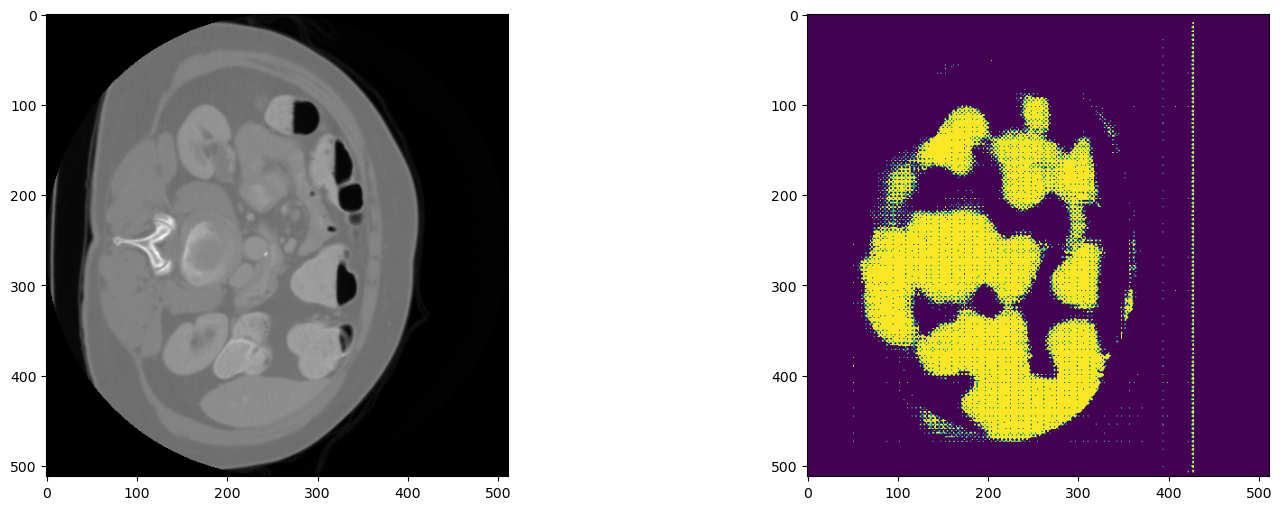

2025-09-18 11:19:36,391 INFO image_writer.py:197 - writing: out\spleen_35\spleen_35_seg.nii.gz


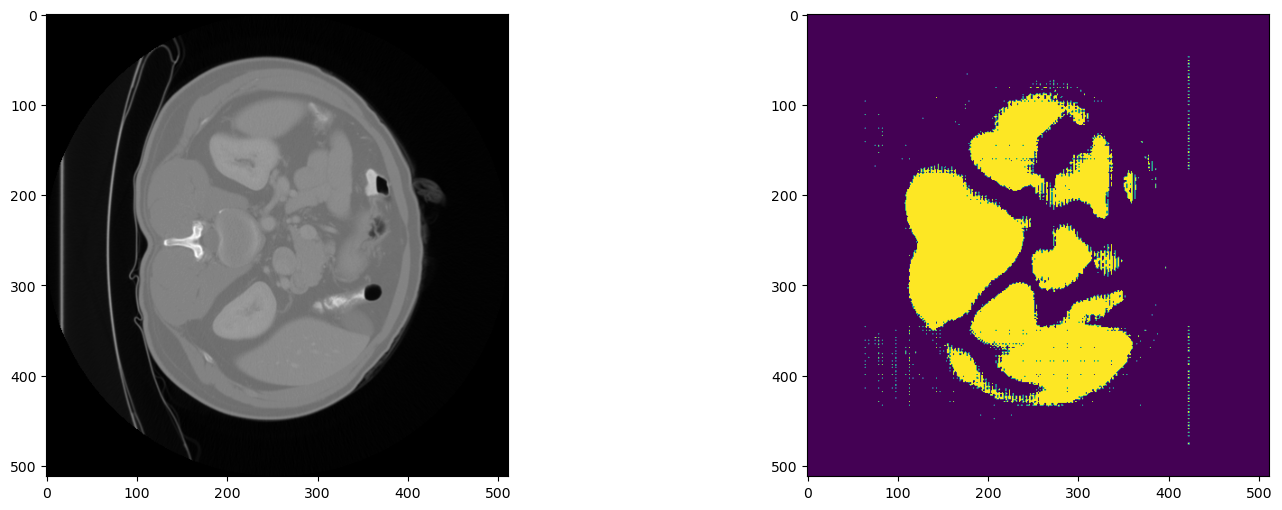

2025-09-18 11:19:37,989 INFO image_writer.py:197 - writing: out\spleen_36\spleen_36_seg.nii.gz


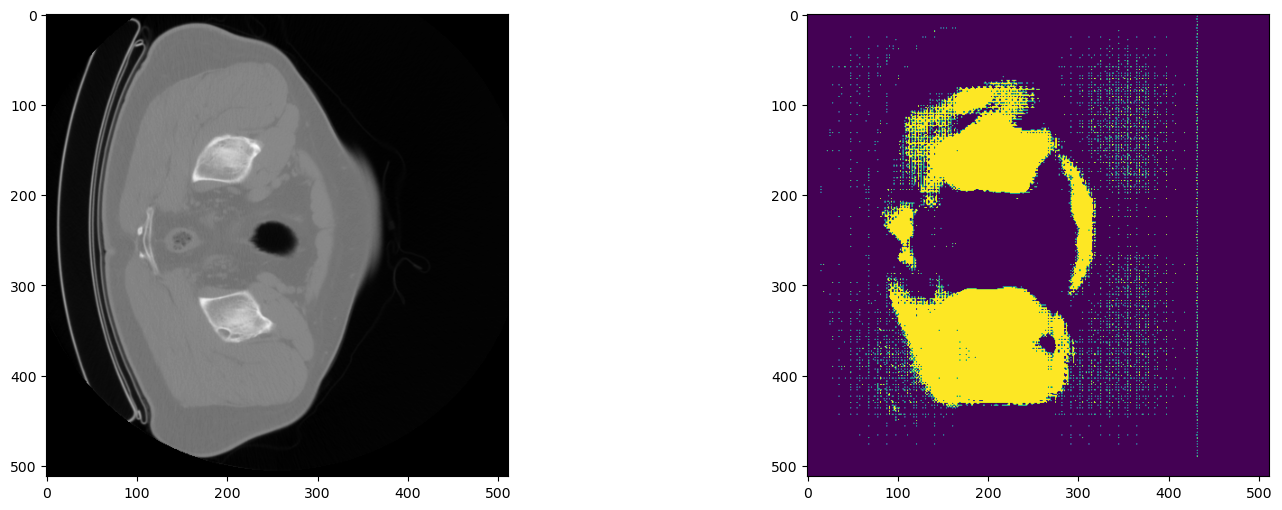

2025-09-18 11:19:40,643 INFO image_writer.py:197 - writing: out\spleen_37\spleen_37_seg.nii.gz


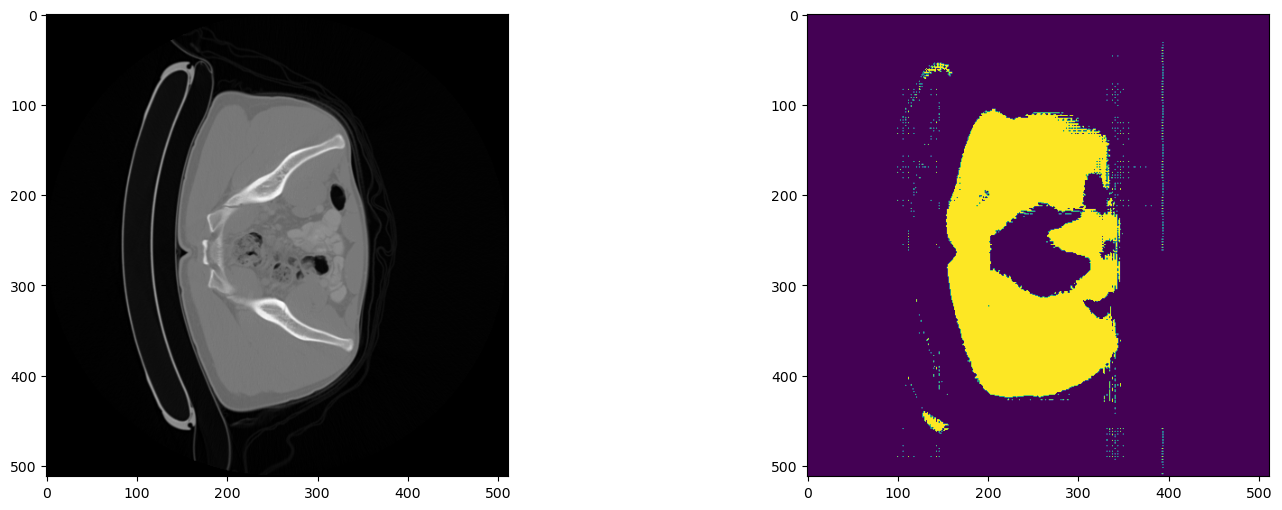

2025-09-18 11:19:43,315 INFO image_writer.py:197 - writing: out\spleen_39\spleen_39_seg.nii.gz


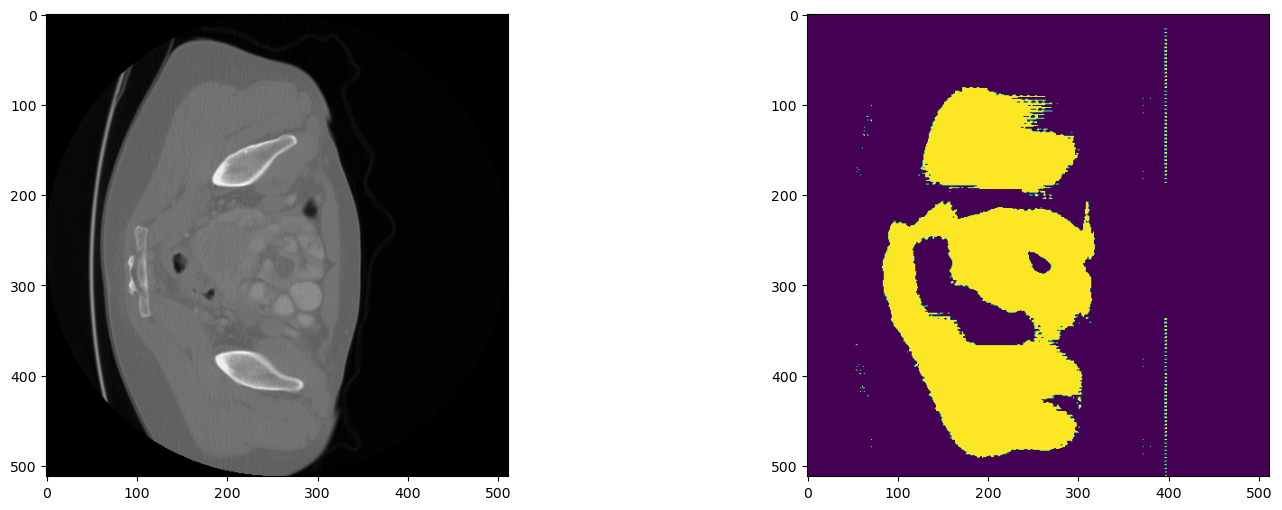

2025-09-18 11:19:45,371 INFO image_writer.py:197 - writing: out\spleen_42\spleen_42_seg.nii.gz


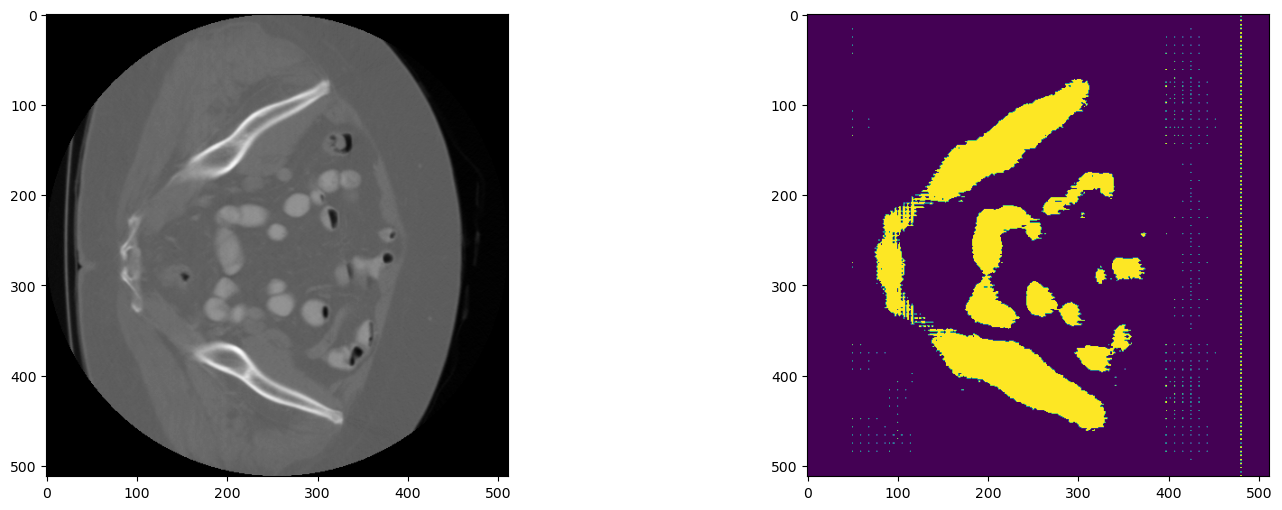

2025-09-18 11:19:47,236 INFO image_writer.py:197 - writing: out\spleen_43\spleen_43_seg.nii.gz


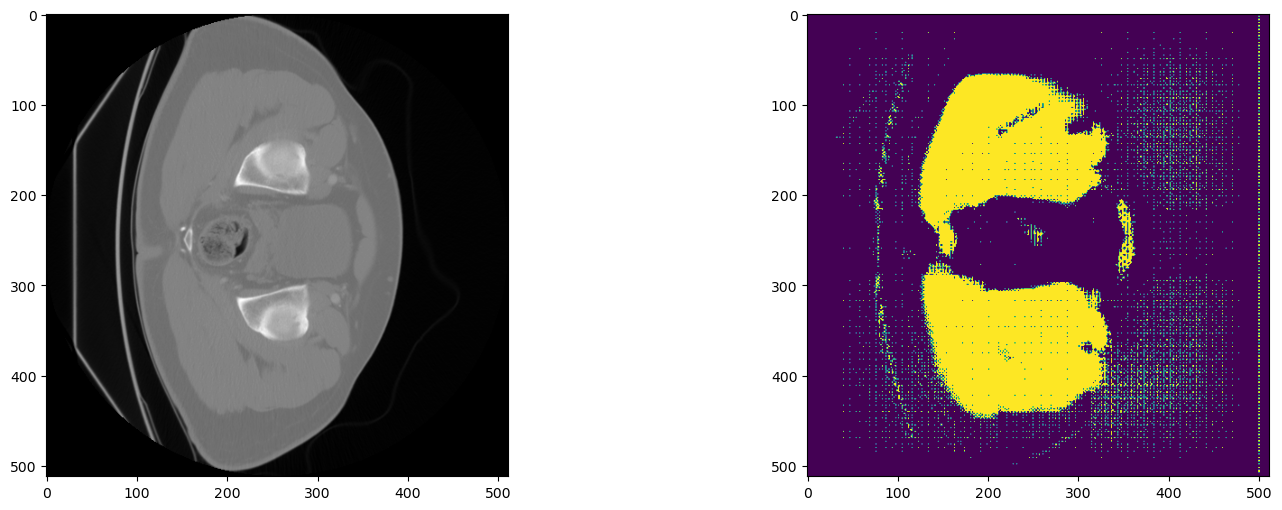

2025-09-18 11:19:49,733 INFO image_writer.py:197 - writing: out\spleen_48\spleen_48_seg.nii.gz


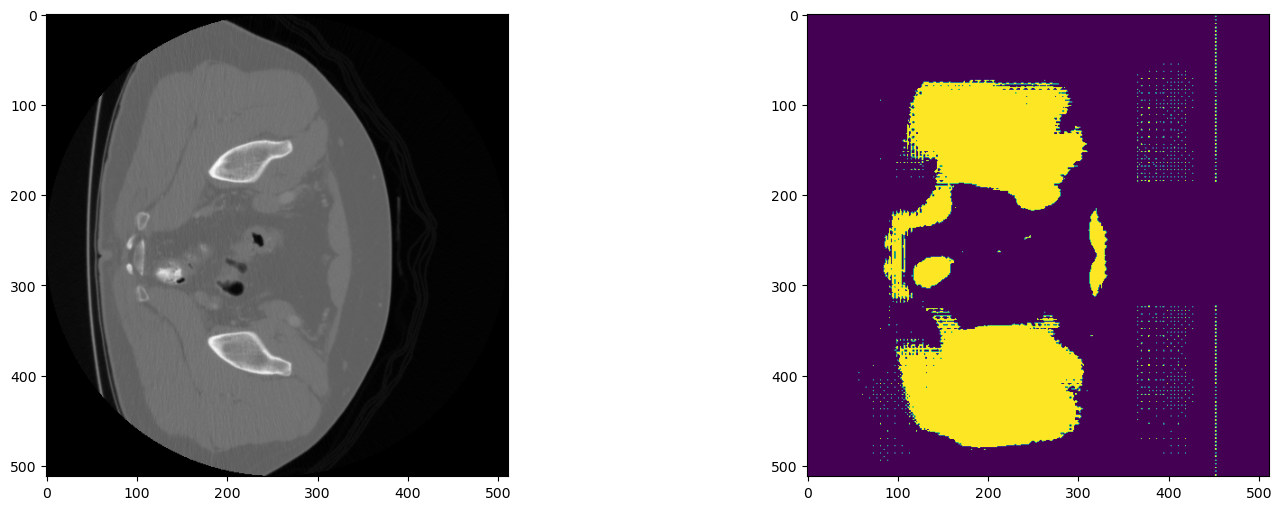

2025-09-18 11:19:51,494 INFO image_writer.py:197 - writing: out\spleen_50\spleen_50_seg.nii.gz


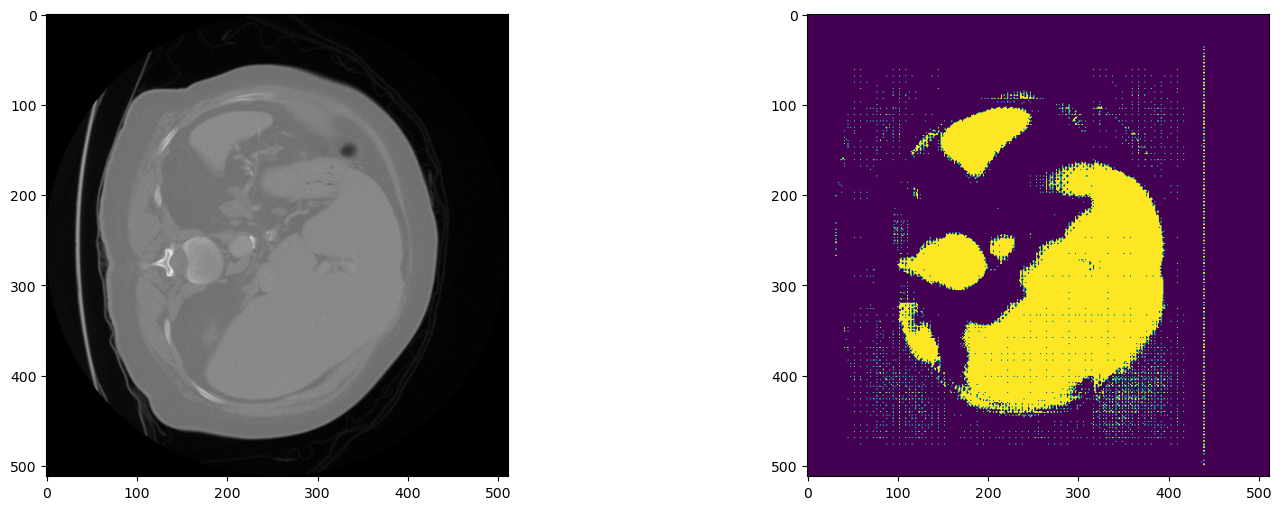

2025-09-18 11:19:52,754 INFO image_writer.py:197 - writing: out\spleen_51\spleen_51_seg.nii.gz


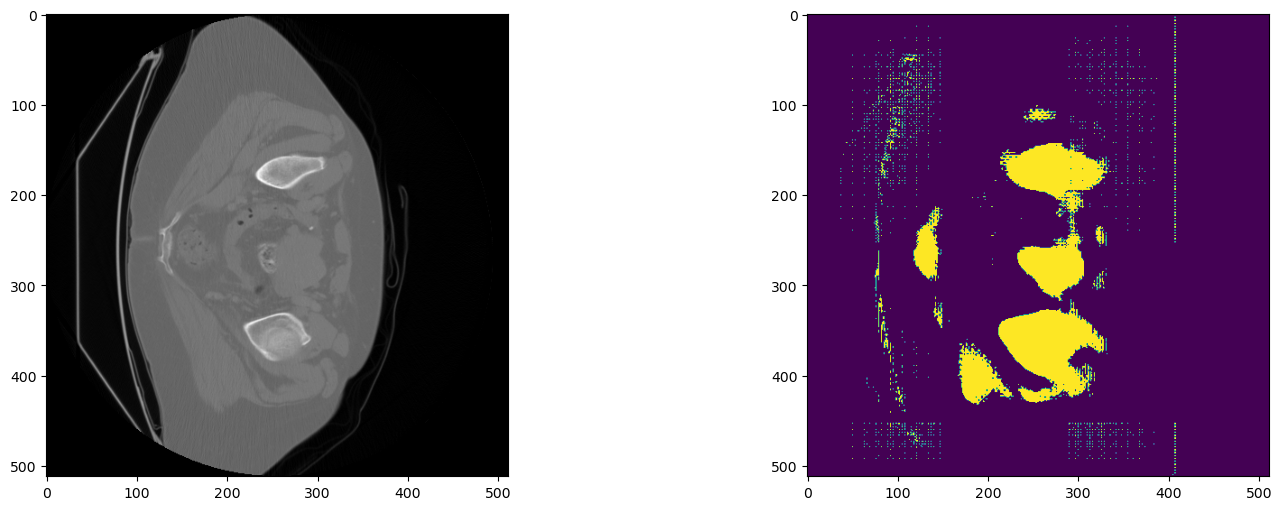

2025-09-18 11:19:54,808 INFO image_writer.py:197 - writing: out\spleen_54\spleen_54_seg.nii.gz


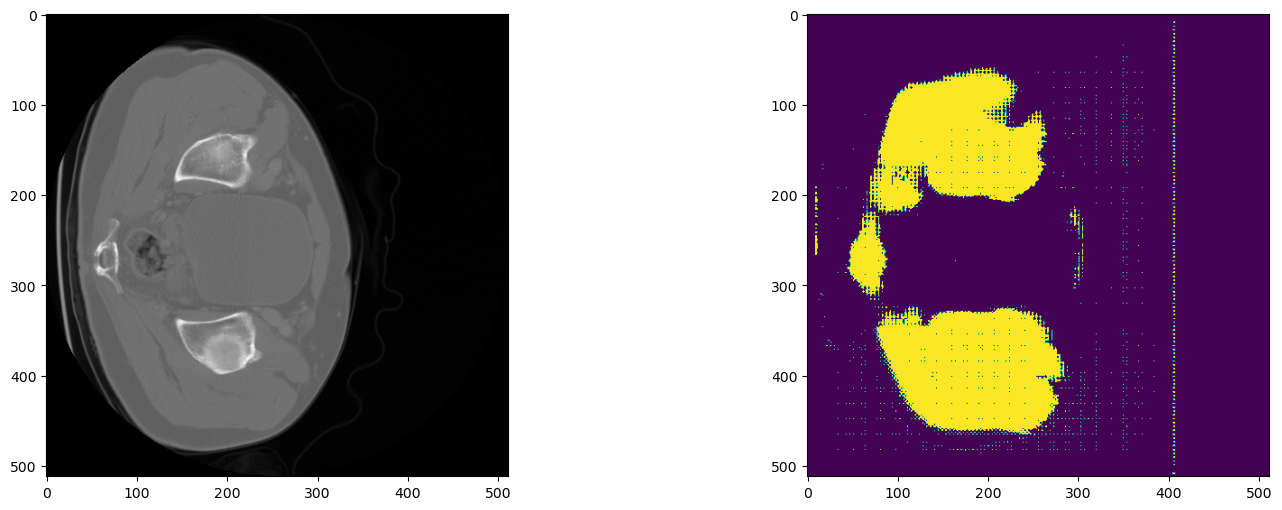

2025-09-18 11:19:57,047 INFO image_writer.py:197 - writing: out\spleen_55\spleen_55_seg.nii.gz


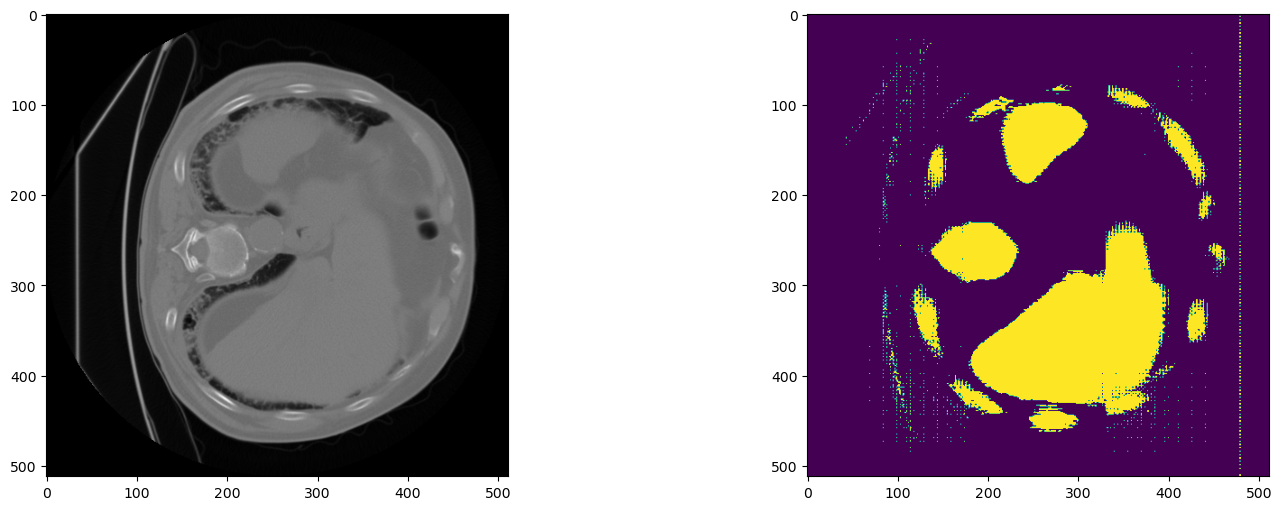

2025-09-18 11:19:58,446 INFO image_writer.py:197 - writing: out\spleen_57\spleen_57_seg.nii.gz


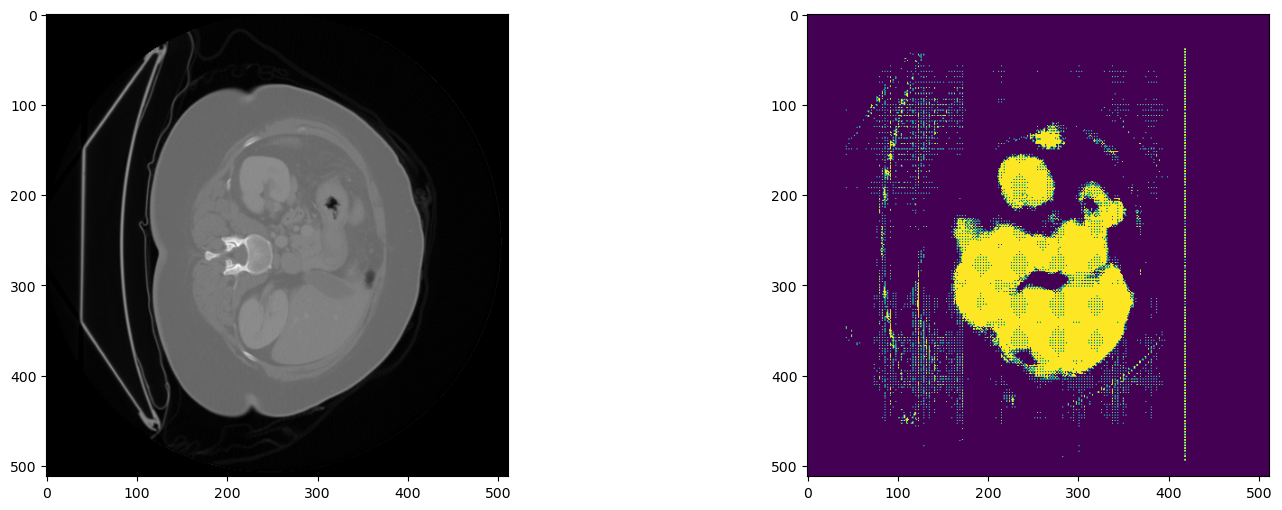

2025-09-18 11:19:59,569 INFO image_writer.py:197 - writing: out\spleen_58\spleen_58_seg.nii.gz


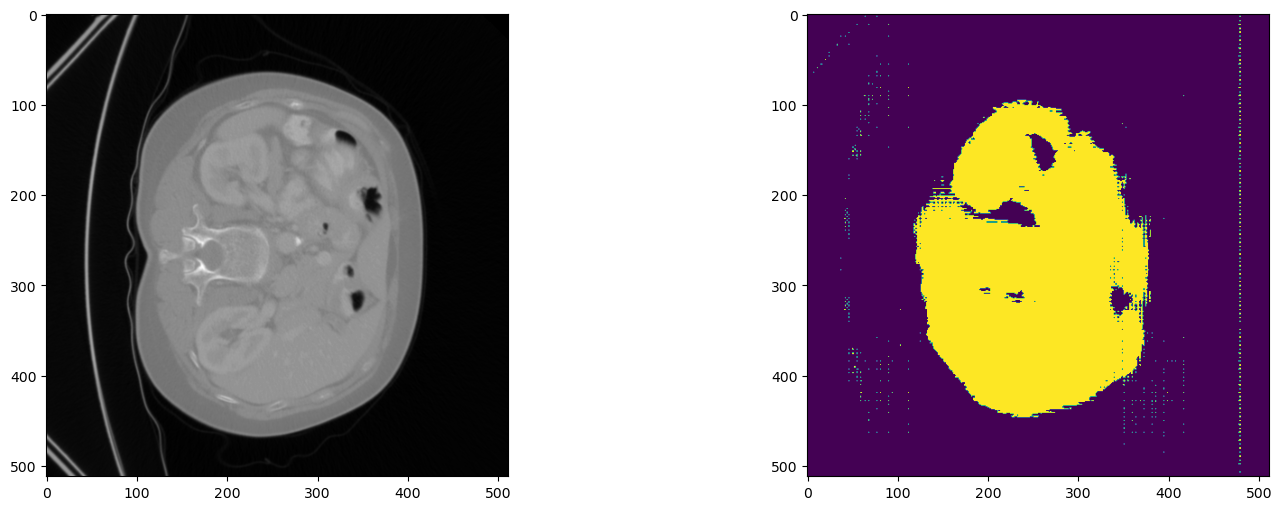

2025-09-18 11:20:00,854 INFO image_writer.py:197 - writing: out\spleen_7\spleen_7_seg.nii.gz


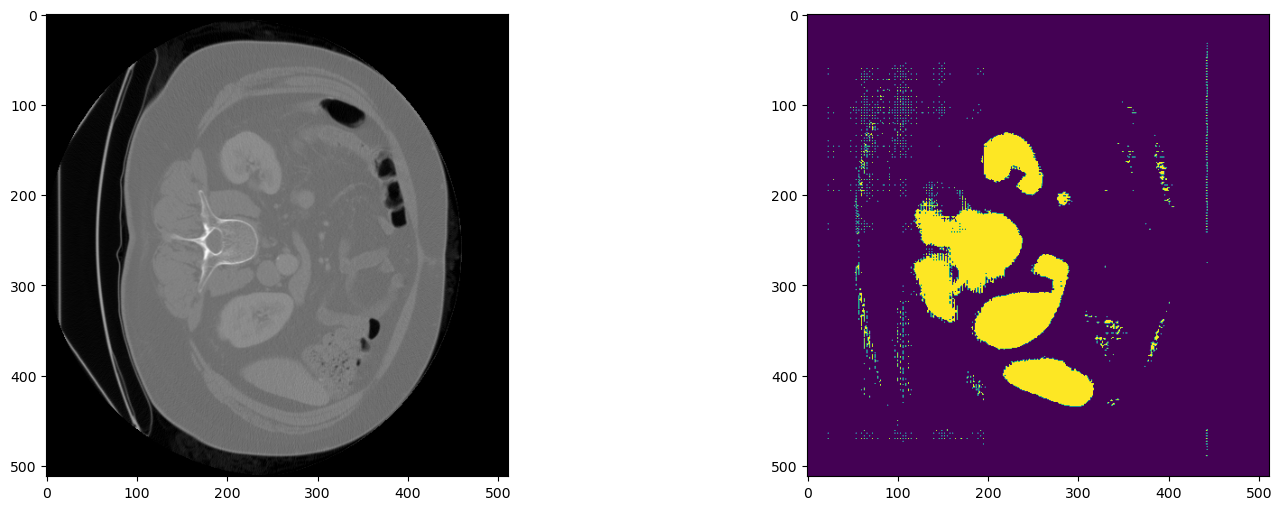

In [22]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth"), weights_only=True))
model.eval()

with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        test_data["pred"] = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model)

        test_data = [post_transforms(i) for i in decollate_batch(test_data)]

        # uncomment the following lines to visualize the predicted results
        test_output = from_engine(["pred"])(test_data)

        original_image = loader(test_output[0].meta["filename_or_obj"])

        plt.figure("check", (18, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(original_image[:, :, 20], cmap="gray")
        plt.subplot(1, 2, 2)
        plt.imshow(test_output[0].detach().cpu()[1, :, :, 20])
        plt.show()

## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)